In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.metrics import fbeta_score
from scipy.stats import norm
from matplotlib import gridspec


from bnn import BNNBayesbyBackprop, gauss_logpdf


/home/emerson/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


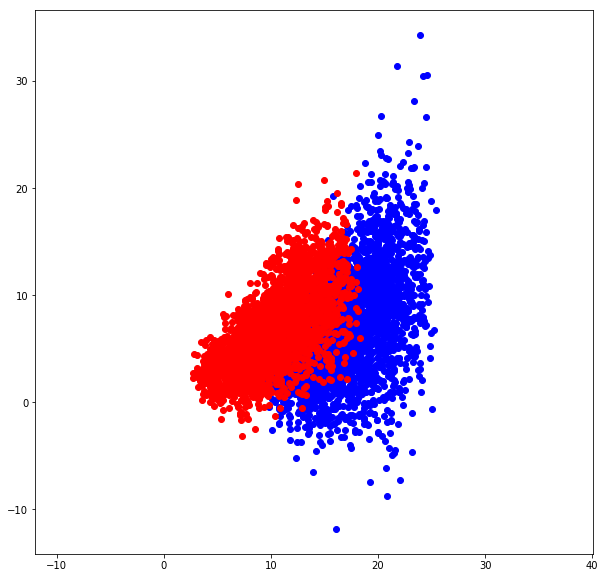

In [2]:
dataset_size = 5000
X_test = np.empty(shape=(dataset_size, 2), dtype=float)
y_test = np.empty(shape=(dataset_size,), dtype=float)
scale = 1


X_test[:int(dataset_size/2), 0] = np.random.uniform(2 * scale, 12 * scale, 
                                                    size=(int(dataset_size/2),))
X_test[:int(dataset_size/2), 1] = np.random.uniform(7.5* scale, 13.5 * scale,
                                                   size=(int(dataset_size/2),))


y_test[:int(dataset_size/2)] = 0
X_test[int(dataset_size/2):,0] = np.random.uniform(2 * scale, 12 * scale,
                                                   size=(int(dataset_size/2),))
X_test[int(dataset_size/2):, 1] = np.random.uniform(0.5 * scale, 6.5 * scale,
                                                    size=(int(dataset_size/2),))
y_test[int(dataset_size/2):] = 1


# shuffle order
perm = np.random.permutation(dataset_size)
X_test = X_test[perm]
y_test = y_test[perm]

A = np.array([[1, 1],
              [1, 0]])
X_test = X_test @ A


w1 = np.array([[0,0]]).T
w2 = np.array([[0,0]]).T
W_full = np.hstack((w1, w2))
b = 0

for i, row_i in enumerate(X_test):
    X_test[i, 1] = X_test[i, 1] + np.random.normal(loc=0, scale= np.exp(0.08 * X_test[i, 0]))
    

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)   

# ax.plot_wireframe(X, Y, zs, color='grey', alpha = 0.7)
ax.scatter(X_test[y_test == 0,0], X_test[y_test == 0,1], c='blue')
ax.scatter(X_test[y_test == 1,0], X_test[y_test == 1,1], c='red')
ax.axis('equal')
fig.show()

plt.savefig("toy_classification.png")

In [3]:
X_train = X_test
y_train = y_test

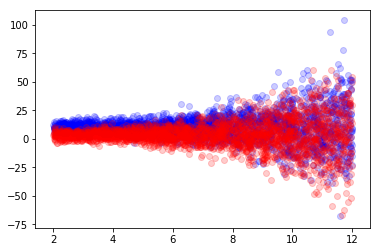

In [63]:
def generateData():
    dataset_size = 5000
    num_negative = 2500
    num_positive = dataset_size - num_negative
    
    X_test = np.empty(shape=(dataset_size, 2), dtype=float)
    y_test = np.empty(shape=(dataset_size,), dtype=float)
    scale = 1

    X_test[:num_negative, 0] = np.random.uniform(2 * scale, 12 * scale, 
                                                        size=num_negative,)
    X_test[:num_negative, 1] = np.random.uniform(7.5* scale, 13.5 * scale,
                                                       size=num_negative,)
    y_test[:num_negative] = 0
    
    
    
    X_test[num_negative:,0] = np.random.uniform(2 * scale, 12 * scale,
                                                       size=num_positive,)
    X_test[num_negative:, 1] = np.random.uniform(0.5 * scale, 6.5 * scale,
                                                        size=num_positive,)
    y_test[num_negative:] = 1
    
    
    
    for i, row_i in enumerate(X_test):
        X_test[i, 1] = X_test[i, 1] + np.random.normal(loc=0, scale= np.exp(0.28 * X_test[i, 0]))

    
    plt.scatter(X_test[y_test == 0,0], X_test[y_test == 0,1], c='blue', alpha=.2)
    plt.scatter(X_test[y_test == 1,0], X_test[y_test == 1,1], c='red', alpha=.2)
    plt.show()
    
    return X_test, y_test




def summaryStatistics(matrix, beta=5, printResults=False):
    tp = matrix[0,0]
    fp = matrix[0,1]
    fn = matrix[1,0]
    tn = matrix[1,1]

    precision = tp / (fp + tp)
    recall = tp / (fn + tp)

    f1 = 2*((precision*recall)/(precision+recall))

    fBeta = (1 + beta**2) * ((precision*recall)/((precision * beta**2) + recall))
    
    if printResults == True:
        print("Precision:\t{}".format(precision))
        print("Recall:\t{}".format(recall))
        print("F1:\t{}".format(f1))
        print("F-Beta (beta={}):\t{}".format(beta, fBeta))
    
    return precision, recall, f1, fBeta
    
    
def prCurve(bnn):
    from sklearn.metrics import confusion_matrix    
    X_test, y_test = generateData()
    pList = []; rList = []; f1List = []; fBList = []
    
    thresholds = np.arange(.01, .99, .05)    
    y_prob = bnn.model.forward(torch.Tensor(X_test), predict = True, threshold=False)
    
    for t in thresholds:
        y_pred = y_prob > t
        
        matrix = confusion_matrix(y_pred, y_test)
        print(matrix)
        print("")
        precision, recall, f1, fBeta = summaryStatistics(matrix, beta = 5)
        pList.append(precision)
        rList.append(recall)
        f1List.append(f1)
        fBList.append(fBeta)
        
    return pList, rList, f1List, fBList
    

X_train, y_train = generateData()

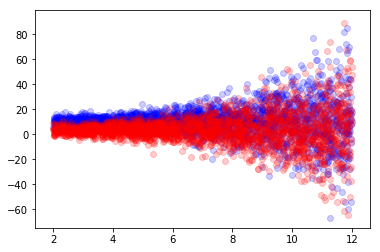

[[   0    0]
 [2500 2500]]

[[   4    2]
 [2496 2498]]

[[  13    6]
 [2487 2494]]



/home/emerson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars


[[  23   16]
 [2477 2484]]

[[  57   28]
 [2443 2472]]

[[  80   49]
 [2420 2451]]

[[ 139   74]
 [2361 2426]]

[[ 219  121]
 [2281 2379]]

[[ 353  191]
 [2147 2309]]

[[ 649  295]
 [1851 2205]]

[[1288  477]
 [1212 2023]]

[[1872  926]
 [ 628 1574]]

[[2138 1604]
 [ 362  896]]

[[2279 2043]
 [ 221  457]]

[[2350 2251]
 [ 150  249]]

[[2410 2353]
 [  90  147]]

[[2455 2423]
 [  45   77]]

[[2483 2468]
 [  17   32]]

[[2493 2489]
 [   7   11]]

[[2498 2498]
 [   2    2]]



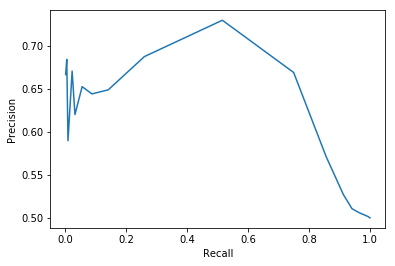

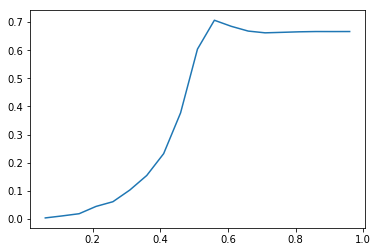

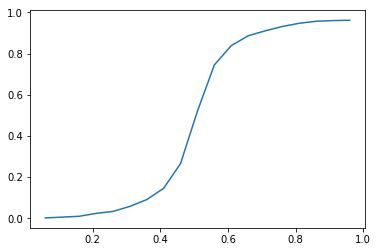

In [64]:
pList, rList, f1List, fBList = prCurve(bnn)

plt.plot(rList, pList)
plt.xlabel("Recall")
plt.ylabel("Precision")
#plt.xlabel("Precision")
#plt.ylabel("Recall")
plt.show()


thresholds = np.arange(.01, .99, .05)    
plt.plot(thresholds, f1List)
plt.show()
plt.plot(thresholds, fBList)
plt.show()

Data being saved in following file:
logging.csv
Epoch:  0 	Loss:  21113.645 	acc:  0.386
Epoch:  1 	Loss:  14913.744 	acc:  0.3984
Epoch:  2 	Loss:  10361.539 	acc:  0.6676
Epoch:  3 	Loss:  6166.896 	acc:  0.49
Epoch:  4 	Loss:  5986.142 	acc:  0.5
Epoch:  5 	Loss:  6323.9194 	acc:  0.6708
Epoch:  6 	Loss:  5450.2495 	acc:  0.6702
Epoch:  7 	Loss:  4574.535 	acc:  0.6722
Epoch:  8 	Loss:  3939.951 	acc:  0.5
Epoch:  9 	Loss:  4240.994 	acc:  0.6674
Epoch:  10 	Loss:  3824.8677 	acc:  0.4672
Epoch:  11 	Loss:  3583.0474 	acc:  0.6876
Epoch:  12 	Loss:  3848.2905 	acc:  0.709
Epoch:  13 	Loss:  3739.4524 	acc:  0.7
Epoch:  14 	Loss:  3573.3335 	acc:  0.6866
Epoch:  15 	Loss:  3680.4302 	acc:  0.6874
Epoch:  16 	Loss:  3729.984 	acc:  0.5838
Epoch:  17 	Loss:  3633.3318 	acc:  0.7048
Epoch:  18 	Loss:  3598.985 	acc:  0.5872
Epoch:  19 	Loss:  3564.9905 	acc:  0.587
Epoch:  20 	Loss:  3600.1763 	acc:  0.6166
Epoch:  21 	Loss:  3484.9548 	acc:  0.6092
Epoch:  22 	Loss:  3678.942 	acc:  0.

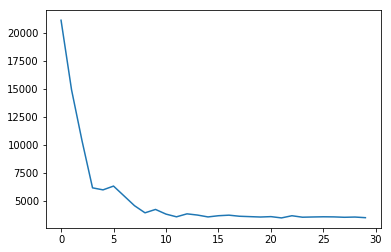

In [8]:
bnn = BNNBayesbyBackprop(prior_mu=0.0, prior_s=1.0, num_MC_samples=100, 
                         linear_regression=False, preset=False, classification=True)


bnn.fit(X_train, y_train, plot=True, n_epochs=30, learning_rate=1e-1, batch_size=1000)

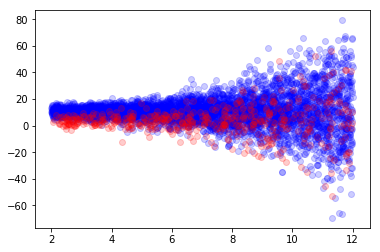

 ---- 4482


array([[4482,   18],
       [ 497,    3]])

In [62]:
confusionMatrix(bnn)

In [26]:
df = pd.read_csv("logging.csv")

df.columns

Index(['mu_l0_w00', 'mu_l0_w10', 'log_s_l0_w00', 'log_s_l0_w10', 'log_prior',
       'log_posterior', 'mean_likelihood', 'reg'],
      dtype='object')

In [57]:
np.zeros(40)
X_sample = np.vstack([np.zeros(21), np.array(list(range(-10,11)))]).T
X_sample = torch.tensor(np.array(X_sample), dtype=torch.float32)


predictions = bnn.model.forward(torch.Tensor(X_train))

sample_pred = bnn.model.forward(X_sample)

y_pred = sample_pred[:,0].detach().numpy()
std_pred = torch.exp(sample_pred[:,1]).detach().numpy()
log_s_pred = sample_pred[:,1].detach().numpy()


print(y_pred)
#print(std_pred)


plt.plot(std_pred)
plt.show()
# Sample variance to add to the y predictions
std_array = []
for scale in std_pred:
    std_array.append(np.random.normal(loc=0, scale=np.exp(scale)))
std_array = np.array((std_array))



plt.scatter(X_sample[:,1], y_pred + std_array, alpha=.1, label='predicted')
plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='real')
plt.title("Y hat and Y values across X1")
plt.legend()
plt.savefig("x1_y.png")

plt.show()



tensor([False, False, False,  ..., False, False, False])


IndexError: too many indices for tensor of dimension 1

In [ ]:

"""
# For constant std dev#
#std_pred = 10 * torch.ones([y_pred.shape[0]], dtype=torch.float64)
# For constant std dev#

#plt.scatter(X_train[:,1], y_pred + std_array, alpha=.1, label='predicted')
#plt.scatter(X_sample[:,1], y_pred, alpha=.1, label='predicted')
plt.errorbar(X_sample[:,1], y_pred, yerr=(std_pred), fmt='o', label='predicted')
plt.scatter(X_train[:,1], y_train, alpha=.1, c='C1', label='real')
plt.ylabel("Y")
plt.xlabel("X")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.title("Predicted and real Y values vs X")
plt.legend()
plt.savefig("x_y1.png")
plt.show()



#stds = []
#Xs = list(range(-10, 11))
#for x in Xs:
#    stds.append(x + b_s)

#std_pred = predictions[:,1].detach().numpy()

real_std = []
for x in range(-10, 11):
    real_std.append(np.exp(np.array([0, x] @ W_s + b_s)))
print(real_std)
# plt.plot(list(range(-10,11)), list(range(0, 21)), c='C3', label='real')
plt.plot(list(range(-10,11)), real_std, c='C3', label='real')
plt.plot(X_sample[:,1], (std_pred), label='predicted')
plt.title("Standard Deviation versus X value")
plt.ylabel("standard deviation")
plt.xlabel("X")
plt.legend()
plt.savefig("std1.png")
# plt.xlim(right = 5)
# plt.xlim(left = -5)
# plt.ylim(top = 100)
# plt.ylim(bottom = -100)
plt.show()"""